In [396]:
import warnings
warnings.filterwarnings('ignore')

In [398]:
import pandas as pd
import numpy as np

In [400]:
np.random.seed(12345)

In [402]:
data = pd.read_csv('GOOG3.csv', parse_dates=True)

In [404]:
# Data columns are:
# opening date, price it opened at, how high it go during the day, how low it go during the day
# closing price of the stock, adjusted closing (considering divident payouts, etc.), buy+sell trade volume in the day.
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-27,82.683998,82.750000,81.287498,81.716499,81.716499,37232000
1,2020-08-28,81.674500,82.358498,81.537498,82.220497,82.220497,29980000
2,2020-08-31,82.394501,82.398247,81.515503,81.709000,81.709000,36468000
3,2020-09-01,81.831497,83.286499,81.611000,83.035500,83.035500,36506000
4,2020-09-02,83.688751,86.658997,83.316498,86.414001,86.414001,50224000


In [406]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
499,2022-08-22,116.099998,116.500000,114.669998,115.070000,115.070000,19316000
500,2022-08-23,114.320000,115.930000,114.300003,114.769997,114.769997,14390700
501,2022-08-24,114.449997,115.717003,113.779999,114.699997,114.699997,16051200
502,2022-08-25,115.150002,117.779999,115.050003,117.699997,117.699997,14874700
503,2022-08-26,115.809998,116.449997,111.250000,111.300003,111.300003,31590470


In [408]:
data.shape

(504, 7)

In [410]:
# Check for the nil / missing values in the dataset. 
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [412]:
# Convert the date value to proper date - time format.
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m-%d")

In [414]:
# Create a new data frame having date and adjusted close value.
df_close = data[['Date','Adj Close']]

In [416]:
# Change the 'date' column to 'y' to use it in the calucations below.
df_close.columns = ['Date','y']

In [418]:
# Sort the value of date column. Replace the values in same data frame. 
# These are precutionary steps so that algorithm does not errors out. 
df_close.sort_values(by='Date', inplace=True)

In [420]:
df_close.head(10)

,Date,y
0,2020-08-27,81.716499
1,2020-08-28,82.220497
2,2020-08-31,81.709000
3,2020-09-01,83.035500
4,2020-09-02,86.414001
5,2020-09-03,82.092003
6,2020-09-04,79.552002
7,2020-09-08,76.619499
8,2020-09-09,77.848000
9,2020-09-10,76.600998


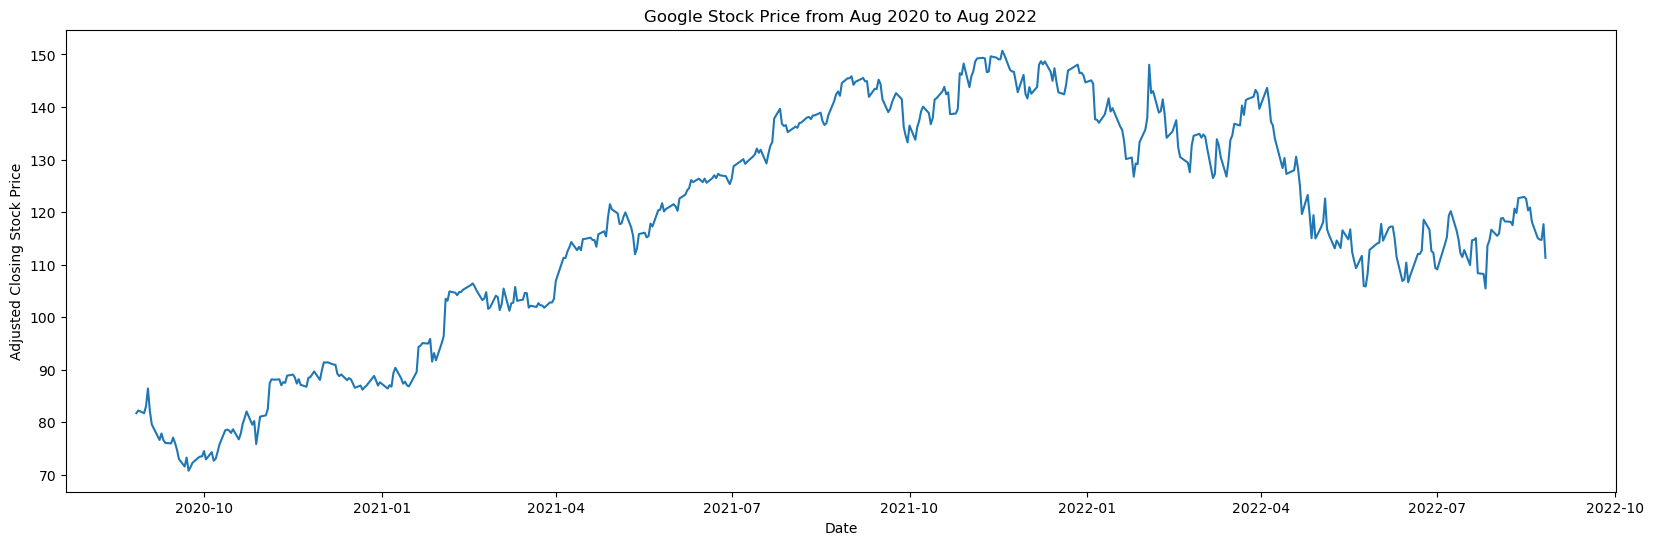

In [422]:
# Plot the stock price. 
# Whenever there is a dip in the prices, forget gate kicks in and it has to remember the long-term memory.
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,6))
sns.lineplot(data=df_close, x='Date',y='y')
plt.title('Google Stock Price from Aug 2020 to Aug 2022')
plt.ylabel('Adjusted Closing Stock Price')
plt.show()

In [423]:
# Prepare the data for LSTM algorithm to consume. 

# 1,2,3,4,5,6,7,8,9,10
#window size = 5

# Given the data sequence of 1 to 10 and considering the window size of 5:
# - in the first sequence, the next data is 6. 
# - in the second sequence, the next data is 7. 
# - in the third sequence, the next data is 8. 

# 1,2,3,4,5 -> 6
# 2,3,4,5,6 -> 7
# 3,4,5,6,7 -> 8

# 6 <- 5,4,3,2,1
# 7 <- 6,5,4,3,2


# So, we define a window size of 45 where we have 45 independent variables (i.e. sequence of 45 values) and take 'y' as predicted value. 
# We are going to use the shift function on the data frame. With this we basically creating the data set shown above. 

# We are creating a data set where the current value is dependent on the previous 45 values (in stead of 5 shown in the example).
# This is also called sequence-based dependencies. 

# Each value has its previous values in the timeseries. 
window_size = 45
for i in range(window_size):
    df_close['y'+str(i+1)] = df_close['y'].shift(i+1)

In [424]:
# We ended up creating a dataset with 46 columns.
# If we start increasing the window size (45+), we start loosing the number of rows. 
# 45 is  good number to look at the accuracy and modeling the timeseries data.

# There might be other ways of creating this data set, but shifting based is the fastest way of creating it. 
df_close.iloc[0:5,:]

,Date,y,y1,y2,y3,y4,y5,y6,y7,y8,...,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45
0,2020-08-27,81.716499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-28,82.220497,81.716499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-31,81.709000,82.220497,81.716499,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-01,83.035500,81.709000,82.220497,81.716499,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-02,86.414001,83.035500,81.709000,82.220497,81.716499,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [428]:
df_close.iloc[46:50,:]

,Date,y,y1,y2,y3,y4,y5,y6,y7,y8,...,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45
46,2020-11-02,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,80.766502,79.665497,...,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500,81.709000,82.220497
47,2020-11-03,82.510498,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,80.766502,...,75.963997,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500,81.709000
48,2020-11-04,87.456497,82.510498,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,...,77.071999,75.963997,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500
49,2020-11-05,88.168503,87.456497,82.510498,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,...,76.044998,77.071999,75.963997,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001


In [430]:
df_close.shape

(504, 47)

In [432]:
# Drop the NaN / nil values from the columns. We are also keeping the axis = 0. 
# Removes rows containing missing values (NaNs). When applied to a DataFrame, 
# this operation iterates through each row, and if any cell within that row contains 
# a missing value, the entire row is dropped from the DataFrame. 

# The inplace=True, updates the values in the same original data frame. 
df_close.dropna(axis=0, inplace=True)

In [434]:
# After dropping the NaN and axis=0 operation, only rwos with complete values are remained. 

# The resulting data frame is called a uni-variate timeseries where there is only one independent timeseries. 
# There are no multiple time series. 
# We are preparing the data for the LSTM to start running. 

# Why dependent timeseries data is required? 
# Why univariate timeseries data is used? 

# On text side, we can visualize the data as below. 
# We like to build data science model.
# We -> like
# We like -> to
# We like to -> build
# We like to build -> data 
# We like to build data -> science
df_close.head()

,Date,y,y1,y2,y3,y4,y5,y6,y7,y8,...,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45
45,2020-10-30,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,80.766502,79.665497,77.796501,...,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500,81.709000,82.220497,81.716499
46,2020-11-02,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,80.766502,79.665497,...,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500,81.709000,82.220497
47,2020-11-03,82.510498,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,80.766502,...,75.963997,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500,81.709000
48,2020-11-04,87.456497,82.510498,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,82.050003,...,77.071999,75.963997,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001,83.035500
49,2020-11-05,88.168503,87.456497,82.510498,81.301498,81.050499,78.362000,75.831001,80.212997,79.522499,...,76.044998,77.071999,75.963997,76.036003,76.600998,77.848000,76.619499,79.552002,82.092003,86.414001


In [436]:
# Split the data into training and test set. 
# We can not split the data using regular train_test_split method because the sequence of observation is important. 
# So we pick a specific date (timeseries data) to split the training and test data. 
# So we train on about 450 records and test on 10 records. These records are used for test the prediction.
df_train = df_close[df_close['Date'] <= pd.to_datetime('2022-08-14')]
df_test = df_close[df_close['Date'] > pd.to_datetime('2022-08-14')]

In [438]:
print(f" Training shape {df_train.shape} Testing Shape {df_test.shape}")

 Training shape (449, 47) Testing Shape (10, 47)


In [440]:
df_train.tail()

,Date,y,y1,y2,y3,y4,y5,y6,y7,y8,...,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45
489,2022-08-08,118.139999,118.220001,118.870003,118.779999,115.900002,115.480003,116.639999,114.589996,113.599998,...,110.390503,107.194000,106.876503,111.427498,114.917999,117.237999,117.229500,117.010498,114.564003,117.746002
490,2022-08-09,117.500000,118.139999,118.220001,118.870003,118.779999,115.900002,115.480003,116.639999,114.589996,...,106.636002,110.390503,107.194000,106.876503,111.427498,114.917999,117.237999,117.229500,117.010498,114.564003
491,2022-08-10,120.650002,117.500000,118.139999,118.220001,118.870003,118.779999,115.900002,115.480003,116.639999,...,107.865501,106.636002,110.390503,107.194000,106.876503,111.427498,114.917999,117.237999,117.229500,117.010498
492,2022-08-11,119.820000,120.650002,117.500000,118.139999,118.220001,118.870003,118.779999,115.900002,115.480003,...,112.014999,107.865501,106.636002,110.390503,107.194000,106.876503,111.427498,114.917999,117.237999,117.229500
493,2022-08-12,122.650002,119.820000,120.650002,117.500000,118.139999,118.220001,118.870003,118.779999,115.900002,...,112.033997,112.014999,107.865501,106.636002,110.390503,107.194000,106.876503,111.427498,114.917999,117.237999


In [442]:
df_test.head(10)

,Date,y,y1,y2,y3,y4,y5,y6,y7,y8,...,y36,y37,y38,y39,y40,y41,y42,y43,y44,y45
494,2022-08-15,122.879997,122.650002,119.820000,120.650002,117.500000,118.139999,118.220001,118.870003,118.779999,...,112.684502,112.033997,112.014999,107.865501,106.636002,110.390503,107.194000,106.876503,111.427498,114.917999
495,2022-08-16,122.510002,122.879997,122.650002,119.820000,120.650002,117.500000,118.139999,118.220001,118.870003,...,118.538002,112.684502,112.033997,112.014999,107.865501,106.636002,110.390503,107.194000,106.876503,111.427498
496,2022-08-17,120.320000,122.510002,122.879997,122.650002,119.820000,120.650002,117.500000,118.139999,118.220001,...,116.622498,118.538002,112.684502,112.033997,112.014999,107.865501,106.636002,110.390503,107.194000,106.876503
497,2022-08-18,120.860001,120.320000,122.510002,122.879997,122.650002,119.820000,120.650002,117.500000,118.139999,...,112.571503,116.622498,118.538002,112.684502,112.033997,112.014999,107.865501,106.636002,110.390503,107.194000
498,2022-08-19,118.120003,120.860001,120.320000,122.510002,122.879997,122.650002,119.820000,120.650002,117.500000,...,112.256500,112.571503,116.622498,118.538002,112.684502,112.033997,112.014999,107.865501,106.636002,110.390503
499,2022-08-22,115.070000,118.120003,120.860001,120.320000,122.510002,122.879997,122.650002,119.820000,120.650002,...,109.372498,112.256500,112.571503,116.622498,118.538002,112.684502,112.033997,112.014999,107.865501,106.636002
500,2022-08-23,114.769997,115.070000,118.120003,120.860001,120.320000,122.510002,122.879997,122.650002,119.820000,...,109.081001,109.372498,112.256500,112.571503,116.622498,118.538002,112.684502,112.033997,112.014999,107.865501
501,2022-08-24,114.699997,114.769997,115.070000,118.120003,120.860001,120.320000,122.510002,122.879997,122.650002,...,113.887001,109.081001,109.372498,112.256500,112.571503,116.622498,118.538002,112.684502,112.033997,112.014999
502,2022-08-25,117.699997,114.699997,114.769997,115.070000,118.120003,120.860001,120.320000,122.510002,122.879997,...,115.213501,113.887001,109.081001,109.372498,112.256500,112.571503,116.622498,118.538002,112.684502,112.033997
503,2022-08-26,111.300003,117.699997,114.699997,114.769997,115.070000,118.120003,120.860001,120.320000,122.510002,...,119.306000,115.213501,113.887001,109.081001,109.372498,112.256500,112.571503,116.622498,118.538002,112.684502


In [444]:
# The above tail and heads of the train and test data confirm that there is no break in the continuty of the data.

# In the training and test data set, we drop and pick the columns such that we generate the X_train and y_train data sets. 
# Note that for X_train, we drop the 'date' and 'y' column for X_train data frame  
#   - (i.e. drop the 'y' and we take every other columns except 'y' column)
# Note that for y_train, we only keep the 'y' column (which is dropped from the X_train). 

# What is the reason we drop the 'y' column? 
X_train = df_train.drop(['Date','y'],axis=1)
y_train = df_train['y']

X_test = df_test.drop(['Date','y'],axis=1)
y_test = df_test['y']

In [446]:
print(f" X Train Shape {X_train.shape} and X Test shape {X_test.shape}")

 X Train Shape (449, 45) and X Test shape (10, 45)


In [448]:
# Scaling standardizes the training data by removing the mean and scaling to unit variance. 
# This is a crucial preprocessing step for many machine learning algorithms to ensure fair treatment of all 
# features and often leads to improved model performance and stability.

# Scaling your training data (and subsequently applying the same scaling to your test data) is often important 
# for the performance and stability of machine learning algorithms:
# Algorithms sensitive to feature scale (gradient-based, distance-based, regulerization)
# Improved model performance. 
# Faster convergence and improving numerical instability. 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [450]:
# Import tensorflow and other required package to build a neural network. 
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout

In [452]:
# Random seed setting is all about reproducibility in the non-deterministic world of neural network training.
# Setting a seed ensures that these random operations behave consistently across different runs.
# The reasons why setting a random seed is crucial:
# - Initialization of Weights: 
# - Shuffling of Data: During training
# Other Random Operations: Neural network training can involve other random operations, such as:
# - Dropout: Randomly deactivating a fraction of neurons during training to prevent overfitting.
# - Data Augmentation: Applying random transformations (e.g., rotations, flips) to the training data to increase its diversity.   
# - Sampling: Randomly selecting subsets of data or features.

# Analogy: if you were trying to bake a cake and you changed the amount of sugar each time you baked it, you wouldn't 
# be able to reliably determine the effect of that sugar change. Setting a random seed is like ensuring all the other 
# ingredients and steps are exactly the same each time you bake, so you can isolate the impact of the sugar.
tf.random.set_seed(12345)

In [454]:
# This is uni=variate timeseries data. We have taken only adjusted close value.
X_train.shape

(449, 45)

In [456]:
# Inform tensorflow that we are using a uni-variate timeseries data. 
# We are going to take shape[0] and shape[1] and add 1 to it. 
# If there are multiple timeseries data are involved, we have to tell tensorflow about the same.

# The new shape of X_train will be (100, 50, 1). This can be interpreted as 100 samples, each with a sequence 
# of 50 time steps (or features), and each time step having 1 channel (or feature dimension).
# In summary, the reshape operation adds a trailing dimension of size 1 to the X_train array, often done to make 
# the data compatible with the input requirements of certain neural network layers, especially convolutional 
# layers that expect a channel dimension.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)


# Ensomble model, bagging, boosting (xgboost) and stacking models in ML.
# - Combining multiple weak models into one to build a stronger prediction model.
# - Combine with market sentiments (text data), company fundamentals, etc. 
# Stock price prediction is typically known as "random walks" -- no one knows how it is going to move.

In [458]:
print(X_train.shape)
print(X_test.shape)

(449, 45, 1)
(10, 45, 1)


In [460]:
model = Sequential()

In [462]:
# Add a new layer to the neural network. Layers are stacked in the order they are added
# Create a new LSTM layer with 128 neurons. 

# This line of code adds an LSTM layer with 128 hidden units to the model. This LSTM layer will process 
# input sequences where each time step has a single feature. It will output a sequence of 128-dimensional 
# hidden states for every time step in the input sequence, and the ReLU activation function will be applied 
# to the output at each time step. This type of layer is often used as a building block for models that need 
# to learn patterns and dependencies in sequential data. 
# The return_sequences=True suggests that this layer is likely followed by another recurrent/time-distributed layer. 
# - It returns full sequence as output. 
# If return_sequence=False, the LSTM layer returns only output the hidden state for the last time step of the input sequence. 
model.add(LSTM(128, 
               activation='relu',
               return_sequences = True,
               input_shape=(None,1)))
model.add(LSTM(128, activation = 'relu'))
#model.add(Dropout(0.2))

In [464]:
# Finally add a dense (output) layer with unit=1 and linear activation. 
# Since this is a regression kind of problem, 
model.add(Dense(units = 1, activation = 'linear'))

In [466]:
# Summary calculations are bit complex. 

# Stacking up two LSTM layers is to improve the quality of the prediction.
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, None, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [468]:
# We are using the 'adam' optimizer. The use of "huber" loss gives a good output. 
# Huber loss is typically used in the reinforcement learning as a loss function.

model.compile(optimizer='adam', 
              loss='huber' , 
              metrics = ['mse'])

In [470]:
# It is also possible to use 'mean-absolute-percentage-error' (MAPE) in ARIMA kind of scenario.
# Mape = Avg(Abs(Actual - Predicted)/Actual)
# 1 - MAPE = Accuracy

In [472]:
# Checkpointing in model: 
# - If we want to save the best model, checkpoint helps to save it in a file. The best model means the least error in the output.
# - Note that early stopping is one type of callback. ModelCheckpoint is another type of callback.
# - The checkpoint will save the model when the error value improves (i.e., error decreases)
cp = tf.keras.callbacks.ModelCheckpoint('GoogModel.keras',
                                        monitor='val_mse', 
                                        #save_weights=True, 
                                        save_best_only = True,
                                        verbose=1)

In [474]:
# Train the model with the training data with number of epochs = 200.
model.fit(X_train, 
          y_train,
          validation_data = (X_test, y_test),
          epochs = 200, 
          callbacks = [cp])

Epoch 1/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 120.8416 - mse: 15084.4141
Epoch 1: val_mse improved from inf to 13721.23242, saving model to GoogModel.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 120.6725 - mse: 15048.4424 - val_loss: 116.5808 - val_mse: 13721.2324
Epoch 2/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 150.9953 - mse: 86775.4609
Epoch 2: val_mse did not improve from 13721.23242
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 148.1957 - mse: 80519.5156 - val_loss: 116.9850 - val_mse: 13815.8623
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 120.1700 - mse: 14912.4609
Epoch 3: val_mse did not improve from 13721.23242
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 120.1517 - mse: 14909.1953 - val_loss: 116.8113 - val_mse: 13775.0215
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 123.0592 - mse: 23691.5801
Epoch 4: val_mse did not improve from 13721.23242
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 122.5291 - mse: 2

In [476]:
# After the traing is complete, load the most optimized model saved. 
# With the loaded model, we perform the training prediction and test prediction.
new_model = tf.keras.models.load_model('GoogModel.keras')

In [478]:
# Perform the prediction on the training data.
y_tr_pred = new_model.predict(X_train)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [479]:
# Perform the prediction on the test data.
y_ts_pred = new_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [482]:
# Import the libraries to calculate the 'mean-absolute-percentage-error' (MAPE) in ARIMA kind of scenario.
# Mape = Avg(Abs(Actual - Predicted)/Actual)
# 1 - MAPE = Accuracy 
from sklearn.metrics import mean_absolute_percentage_error

In [484]:
print(f"Training set accuracy : {np.round(100 - mean_absolute_percentage_error(y_true = y_train, y_pred = y_tr_pred)*100,2)}%")

Training set accuracy : 98.21%


In [486]:
print(f"Test set accuracy : {np.round(100 - mean_absolute_percentage_error(y_true = y_test, y_pred = y_ts_pred)*100,2)}%")

Test set accuracy : 98.36%


In [492]:
# Prepare a new data frame with the actual and predicted training data value columns. 
# This data frame is used to visualize the accuracy of the prediction as a line plot.
df1 = df_train[['Date','y']]
df1['Pred'] = y_tr_pred

In [494]:
df1.head()

,Date,y,Pred
45,2020-10-30,81.050499,85.337036
46,2020-11-02,81.301498,85.207878
47,2020-11-03,82.510498,85.543060
48,2020-11-04,87.456497,86.316147
49,2020-11-05,88.168503,87.088867


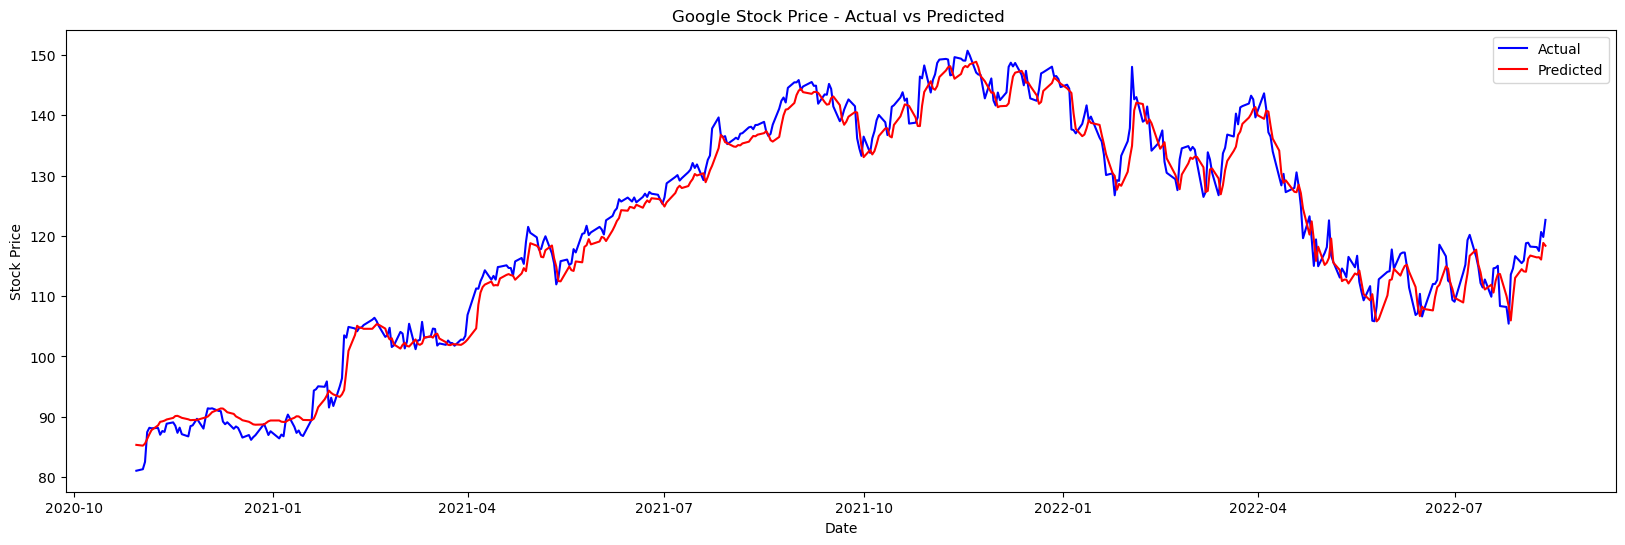

In [496]:
# Prepare a line plot of actual vs predicted value of the training data of the google stock.
plt.figure(figsize = (20,6))
plt.plot(df1['Date'], df1['y'],color='blue', label='Actual')
plt.plot(df1['Date'], df1['Pred'],color='red', label='Predicted')
plt.title("Google Stock Price - Actual vs Predicted " )
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [498]:
# Perform the similar visualization of the actual test and predicted test data values.
new_test_df = df_test[['Date','y']].copy()

In [500]:
# Prepare a new data frame with the actual and predicted test data value columns. 
# This data frame is used to visualize the accuracy of the prediction as a line plot.
new_test_df['yhat'] = y_ts_pred

In [502]:
new_test_df

,Date,y,yhat
494,2022-08-15,122.879997,120.525742
495,2022-08-16,122.510002,120.942940
496,2022-08-17,120.320000,120.865616
497,2022-08-18,120.860001,119.396706
498,2022-08-19,118.120003,119.793976
499,2022-08-22,115.070000,117.636459
500,2022-08-23,114.769997,115.270935
501,2022-08-24,114.699997,114.474152
502,2022-08-25,117.699997,114.333771
503,2022-08-26,111.300003,116.166275


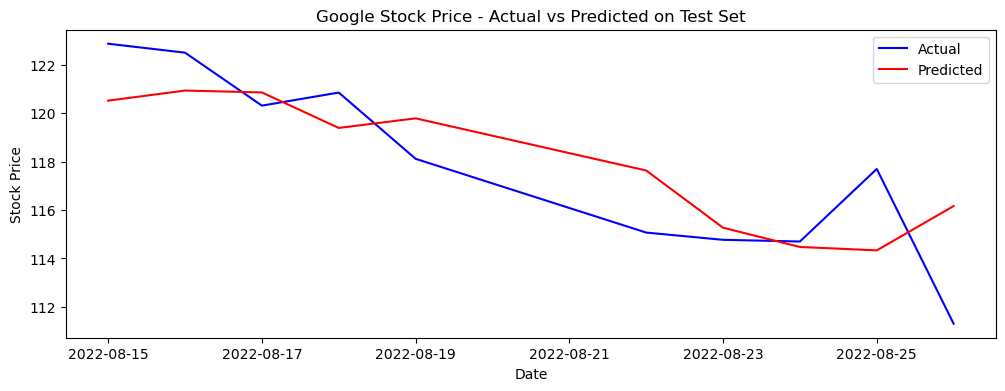

In [504]:
# Prepare a line plot of actual vs predicted value of the test data of the google stock.
plt.figure(figsize = (12,4))
plt.plot(new_test_df['Date'], new_test_df['y'],color='blue', label='Actual')
plt.plot(new_test_df['Date'], new_test_df['yhat'],color='red', label='Predicted')
plt.title("Google Stock Price - Actual vs Predicted on Test Set" )
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [ ]:
# Summary
# - Modeling of LSTM on sequential (timeseries) data. 
# - LSTM has performed more better on the NLP data. 
# - 